# MOH – Motor de Orientação de Habilidades (Dynamic Programming)

Trabalho Global Solution – Engenharia de Software

**Participantes**

- Arthur Fellipe Estevão da Silva – RM553320  
- Eduardo Pires Escudero – RM556527  
- Leonardo Munhoz Prado – RM556824  

---

Este notebook implementa um Motor de Orientação de Habilidades (MOH) capaz de:

- modelar um grafo de habilidades e pré-requisitos  
- resolver problemas de seleção ótima com restrições (Dynamic Programming / busca exaustiva)  
- simular incerteza via Monte Carlo  
- avaliar ordens críticas de aprendizado  
- comparar heurísticas gulosas com solução ótima  
- ordenar habilidades por complexidade  
- sugerir próximas habilidades com base em cenários de mercado  

Tudo foi pensado para atender aos critérios de avaliação: modelagem, implementação, validação do grafo, análise experimental e qualidade de código.

In [1]:
#@title 1. Imports e configurações gerais

from __future__ import annotations

import itertools
import math
import random
import time
from dataclasses import dataclass
from typing import Dict, List, Tuple, Iterable, Optional

import statistics as stats
import pandas as pd
import matplotlib.pyplot as plt

# limites padrão do enunciado (podem ser alterados em testes)
MAX_TEMPO_PADRAO = 350
MAX_COMPLEXIDADE_PADRAO = 30
RANDOM_SEED = 42

random.seed(RANDOM_SEED)

plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["axes.grid"] = True


## 2. Dados de entrada (habilidades)

O MOH trabalha em cima de uma tabela de habilidades com as colunas:

- `id` – identificador da habilidade (S1, S2, …, H12)  
- `valor` – contribuição da habilidade para a carreira  
- `tempo` – esforço estimado (horas)  
- `complexidade` – nível de dificuldade  
- `prereqs` – lista de pré-requisitos (separados por `;` no CSV)

Para facilitar os testes, o notebook suporta **duas formas de entrada**:

1. Um arquivo `skills_base.csv` (recomendado para o trabalho final).  
2. Um dicionário definido diretamente no código (usado como fallback).

O arquivo `skills_base.csv` deve ter, por exemplo:

```text
id,valor,tempo,complexidade,prereqs
S1,10,40,3,
S2,8,30,2,
S3,15,50,4,S1
...
H12,30,90,7,S8;S9


In [7]:
#@title 2.1. Leitura do CSV e fallback para dicionário interno

def carregar_skills_de_csv(caminho: str) -> Dict[str, Dict]:
    """
    Lê o arquivo CSV de habilidades e devolve no formato de dicionário.
    """
    df = pd.read_csv(caminho)
    dados: Dict[str, Dict] = {}

    for _, row in df.iterrows():
        sid = str(row["id"])
        prereq_str = str(row.get("prereqs", "")).strip()
        if prereq_str in ("", "nan"):
            prereqs = []
        else:
            prereqs = [p.strip() for p in prereq_str.split(";") if p.strip()]

        dados[sid] = {
            "valor": float(row["valor"]),
            "tempo": float(row["tempo"]),
            "complexidade": float(row["complexidade"]),
            "prereqs": prereqs,
        }
    return dados


# Fallback de exemplo (SUBSTITUIR pelos valores oficiais do PDF se não usar CSV)
skills_base_data_fallback: Dict[str, Dict] = {
    "S1": {"valor": 10, "tempo": 40, "complexidade": 3, "prereqs": []},
    "S2": {"valor": 8,  "tempo": 30, "complexidade": 2, "prereqs": []},
    "S3": {"valor": 15, "tempo": 50, "complexidade": 4, "prereqs": ["S1"]},
    "S4": {"valor": 12, "tempo": 45, "complexidade": 3, "prereqs": ["S2"]},
    "S5": {"valor": 18, "tempo": 60, "complexidade": 5, "prereqs": ["S3"]},
    "S6": {"valor": 14, "tempo": 40, "complexidade": 3, "prereqs": ["S3"]},
    "S7": {"valor": 20, "tempo": 70, "complexidade": 5, "prereqs": ["S4", "S5"]},
    "S8": {"valor": 22, "tempo": 80, "complexidade": 6, "prereqs": ["S5"]},
    "S9": {"valor": 16, "tempo": 55, "complexidade": 4, "prereqs": ["S6"]},
    "H10": {"valor": 24, "tempo": 75, "complexidade": 5, "prereqs": ["S7"]},
    "H11": {"valor": 26, "tempo": 85, "complexidade": 6, "prereqs": ["S8"]},
    "H12": {"valor": 30, "tempo": 90, "complexidade": 7, "prereqs": ["S8", "S9"]},
}

def gerar_cenario_variado(
    base: Dict[str, Dict],
    variacao_valor: float = 0.10,
    variacao_tempo: float = 0.10,
) -> Dict[str, Dict]:
    """
    Gera um cenário alternativo a partir da base, mexendo um pouco em valor/tempo.
    """
    novo = {}
    for sid, info in base.items():
        fator_v = random.uniform(1 - variacao_valor, 1 + variacao_valor)
        fator_t = random.uniform(1 - variacao_tempo, 1 + variacao_tempo)
        novo[sid] = {
            "valor": info["valor"] * fator_v,
            "tempo": info["tempo"] * fator_t,
            "complexidade": info["complexidade"],
            "prereqs": list(info["prereqs"]),
        }
    return novo

In [8]:
#@title 2.2. Escolher fonte de dados (CSV ou dicionário interno)

usar_csv = True  #@param {type:"boolean"}
caminho_csv = "skills_base.csv"  #@param {type:"string"}

if usar_csv:
    print(f"Lendo habilidades a partir de {caminho_csv}...")
    skills_base_data = carregar_skills_de_csv(caminho_csv)
else:
    print("Usando dicionário interno como base de habilidades.")
    skills_base_data = skills_base_data_fallback

display(pd.DataFrame.from_dict(skills_base_data, orient="index"))


Usando dicionário interno como base de habilidades.


,valor,tempo,complexidade,prereqs
S1,10,40,3,[]
S2,8,30,2,[]
S3,15,50,4,[S1]
S4,12,45,3,[S2]
S5,18,60,5,[S3]
S6,14,40,3,[S3]
S7,20,70,5,"[S4, S5]"
S8,22,80,6,[S5]
S9,16,55,4,[S6]
H10,24,75,5,[S7]


In [9]:
#@title 2.3. Gerar arquivo de entrada `skills_base.csv` a partir dos dados atuais

def salvar_skills_csv(skills_data: Dict[str, Dict], caminho: str = "skills_base.csv"):
    """
    Salva o dicionário de habilidades no formato CSV esperado pelo trabalho.
    """
    linhas = []
    for sid, info in skills_data.items():
        prereqs = ";".join(info["prereqs"]) if info.get("prereqs") else ""
        linhas.append({
            "id": sid,
            "valor": info["valor"],
            "tempo": info["tempo"],
            "complexidade": info["complexidade"],
            "prereqs": prereqs,
        })

    df = pd.DataFrame(linhas, columns=["id", "valor", "tempo", "complexidade", "prereqs"])
    df.to_csv(caminho, index=False, encoding="utf-8")
    return df

df_entrada = salvar_skills_csv(skills_base_data)
print("Arquivo `skills_base.csv` gerado com sucesso.")
display(df_entrada)


Arquivo `skills_base.csv` gerado com sucesso.


,id,valor,tempo,complexidade,prereqs
0,S1,10,40,3,
1,S2,8,30,2,
2,S3,15,50,4,S1
3,S4,12,45,3,S2
4,S5,18,60,5,S3
5,S6,14,40,3,S3
6,S7,20,70,5,S4;S5
7,S8,22,80,6,S5
8,S9,16,55,4,S6
9,H10,24,75,5,S7


## 3. Modelagem do grafo de habilidades

A modelagem segue dois níveis:

- `Skill`: representa uma habilidade individual.  
- `SkillGraph`: agrupa todas as habilidades e expõe operações de apoio (buscar pré-requisitos, listar habilidades, etc.).

Essa estrutura será reutilizada em todos os desafios.


In [10]:
#@title 3.1. Classes principais

@dataclass(frozen=True)
class Skill:
    id: str
    valor: float
    tempo: float
    complexidade: float
    prereqs: List[str]


class SkillGraph:
    def __init__(self, skills_data: Dict[str, Dict]):
        self.skills: Dict[str, Skill] = {}
        for sid, info in skills_data.items():
            self.skills[sid] = Skill(
                id=sid,
                valor=float(info["valor"]),
                tempo=float(info["tempo"]),
                complexidade=float(info["complexidade"]),
                prereqs=list(info["prereqs"]),
            )

    def get_skill(self, sid: str) -> Skill:
        return self.skills[sid]

    def all_ids(self) -> List[str]:
        return list(self.skills.keys())

    def get_prereqs(self, sid: str) -> List[str]:
        return self.skills[sid].prereqs

    def skills_without_prereqs(self) -> List[Skill]:
        return [s for s in self.skills.values() if not s.prereqs]


## 4. Validação do grafo

Antes de usar o grafo em algoritmos de otimização, garantimos:

- não existem pré-requisitos “fantasmas”;  
- não há ciclos;  
- existe uma ordenação topológica possível.

Isso se conecta diretamente com o critério de **validação do grafo** na rubrica.


In [12]:
#@title 4.1. Funções de validação do grafo

def check_missing_prereqs(graph: SkillGraph) -> List[str]:
    erros = []
    ids = set(graph.all_ids())
    for sid in graph.all_ids():
        for p in graph.get_prereqs(sid):
            if p not in ids:
                erros.append(f"Pré-requisito {p} usado em {sid} não está cadastrado.")
    return erros


def has_cycle(graph: SkillGraph) -> bool:
    visitados = set()
    pilha = set()

    def dfs(u: str) -> bool:
        visitados.add(u)
        pilha.add(u)
        for v in graph.get_prereqs(u):
            if v not in visitados:
                if dfs(v):
                    return True
            elif v in pilha:
                return True
        pilha.remove(u)
        return False

    for sid in graph.all_ids():
        if sid not in visitados:
            if dfs(sid):
                return True
    return False


def topological_sort(graph: SkillGraph) -> Optional[List[str]]:
    """
    Implementação simples de Kahn para obter uma ordem possível.
    """
    in_deg = {sid: 0 for sid in graph.all_ids()}
    for sid in graph.all_ids():
        for p in graph.get_prereqs(sid):
            in_deg[sid] += 1

    fila = [sid for sid, deg in in_deg.items() if deg == 0]
    ordem = []

    while fila:
        u = fila.pop(0)
        ordem.append(u)
        for v in graph.all_ids():
            if u in graph.get_prereqs(v):
                in_deg[v] -= 1
                if in_deg[v] == 0:
                    fila.append(v)

    if len(ordem) != len(graph.all_ids()):
        return None
    return ordem


def validate_graph(graph: SkillGraph) -> List[str]:
    mensagens = []

    missing = check_missing_prereqs(graph)
    mensagens.extend(missing)

    if has_cycle(graph):
        mensagens.append("⚠️ O grafo tem ciclo (não é um DAG).")
    else:
        mensagens.append("✅ Grafo acíclico.")
        ordem = topological_sort(graph)
        mensagens.append(f"Ordenação topológica possível: {ordem}")

    if not missing and not has_cycle(graph):
        mensagens.append("✔️ Validação geral: grafo consistente.")
    return mensagens


In [13]:
#@title 4.2. Rodando a validação do grafo

graph_base = SkillGraph(skills_base_data)

print("=== Validação do grafo de habilidades ===")
for msg in validate_graph(graph_base):
    print("-", msg)


=== Validação do grafo de habilidades ===
- ✅ Grafo acíclico.
- Ordenação topológica possível: ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'H10', 'H11', 'H12']
- ✔️ Validação geral: grafo consistente.


## 5. Desafio 1 – Seleção ótima + Monte Carlo

Objetivo:

- escolher um conjunto de habilidades que maximize o **valor total**,  
- respeitando as restrições de **tempo** e **complexidade** globais,  
- e comparando a solução determinística com o comportamento em cenários com incerteza (Monte Carlo).

Como o número de habilidades é baixo (12), usamos uma busca completa em todos os subconjuntos (2¹² = 4096).


In [14]:
#@title 5.1. Avaliação de subconjuntos

def avaliar_subset(
    graph: SkillGraph,
    subset_ids: Iterable[str],
    max_tempo: float,
    max_complexidade: float,
    checar_prereqs: bool = True,
) -> Tuple[bool, float, float, float]:
    """
    Checa se um conjunto de habilidades é válido e calcula seus totais.
    """
    subset_ids = list(subset_ids)
    subset_set = set(subset_ids)

    tempo_total = 0.0
    compl_total = 0.0
    valor_total = 0.0

    for sid in subset_ids:
        skill = graph.get_skill(sid)
        if checar_prereqs and not set(skill.prereqs).issubset(subset_set):
            return False, 0.0, 0.0, 0.0

        tempo_total += skill.tempo
        compl_total += skill.complexidade
        valor_total += skill.valor

    if tempo_total > max_tempo or compl_total > max_complexidade:
        return False, tempo_total, compl_total, valor_total

    return True, tempo_total, compl_total, valor_total


In [15]:
#@title 5.2. Busca exaustiva determinística

def solve_deterministic_exaustivo(
    graph: SkillGraph,
    max_tempo: float = MAX_TEMPO_PADRAO,
    max_complexidade: float = MAX_COMPLEXIDADE_PADRAO,
    checar_prereqs: bool = True,
) -> Tuple[float, List[str], Dict]:
    """
    Testa todos os subconjuntos possíveis e guarda o melhor.
    """
    ids = graph.all_ids()
    n = len(ids)

    melhor_valor = -math.inf
    melhor_subset: List[str] = []

    avaliados = 0
    inicio = time.perf_counter()

    for mask in range(1 << n):
        subset = [ids[i] for i in range(n) if mask & (1 << i)]
        factivel, tempo_total, compl_total, valor_total = avaliar_subset(
            graph, subset, max_tempo, max_complexidade, checar_prereqs
        )
        avaliados += 1
        if factivel and valor_total > melhor_valor:
            melhor_valor = valor_total
            melhor_subset = subset

    fim = time.perf_counter()
    stats_exec = {
        "subconjuntos_avaliados": avaliados,
        "tempo_execucao_s": fim - inicio,
    }
    return melhor_valor, melhor_subset, stats_exec


In [16]:
#@title 5.3. Resultado determinístico e tabela de habilidades escolhidas

valor_max, subset_max, stats_exec = solve_deterministic_exaustivo(graph_base)
print("Melhor valor encontrado:", valor_max)
print("Conjunto escolhido:", subset_max)
print("Estatísticas de execução:", stats_exec)

df_escolhidas = (
    pd.DataFrame(
        [
            {
                "id": sid,
                "valor": graph_base.get_skill(sid).valor,
                "tempo": graph_base.get_skill(sid).tempo,
                "complexidade": graph_base.get_skill(sid).complexidade,
            }
            for sid in subset_max
        ]
    )
    .set_index("id")
)

df_totais = pd.DataFrame(
    {
        "valor_total": [df_escolhidas["valor"].sum()],
        "tempo_total": [df_escolhidas["tempo"].sum()],
        "complexidade_total": [df_escolhidas["complexidade"].sum()],
    }
)

print("\nHabilidades escolhidas:")
display(df_escolhidas)
print("Totais:")
display(df_totais)


Melhor valor encontrado: 99.0
Conjunto escolhido: ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S8']
Estatísticas de execução: {'subconjuntos_avaliados': 4096, 'tempo_execucao_s': 0.010888269000020045}

Habilidades escolhidas:


,valor,tempo,complexidade
id,,,
S1,10.0,40.0,3.0
S2,8.0,30.0,2.0
S3,15.0,50.0,4.0
S4,12.0,45.0,3.0
S5,18.0,60.0,5.0
S6,14.0,40.0,3.0
S8,22.0,80.0,6.0


Totais:


,valor_total,tempo_total,complexidade_total
0,99.0,345.0,26.0


In [17]:
#@title 5.4. Simulação Monte Carlo

def simulate_monte_carlo(
    base_data: Dict[str, Dict],
    n_scenarios: int = 500,
    max_tempo: float = MAX_TEMPO_PADRAO,
    max_complexidade: float = MAX_COMPLEXIDADE_PADRAO,
    variacao_valor: float = 0.10,
) -> Dict:
    """
    Roda vários cenários aleatórios alterando o valor das habilidades
    e aplica a solução determinística em cada um.
    """
    valores_totais = []
    solucoes = []

    inicio = time.perf_counter()
    for _ in range(n_scenarios):
        data_cenario = gerar_cenario_variado(
            base_data,
            variacao_valor=variacao_valor,
            variacao_tempo=0.0,
        )
        g = SkillGraph(data_cenario)
        valor_max, subset_max, _ = solve_deterministic_exaustivo(
            g, max_tempo=max_tempo, max_complexidade=max_complexidade
        )
        valores_totais.append(valor_max)
        solucoes.append(tuple(sorted(subset_max)))
    fim = time.perf_counter()

    freq_solucoes: Dict[Tuple[str, ...], int] = {}
    for sol in solucoes:
        freq_solucoes[sol] = freq_solucoes.get(sol, 0) + 1

    media = stats.mean(valores_totais)
    desvio = stats.pstdev(valores_totais) if len(valores_totais) > 1 else 0.0

    return {
        "media_valor": media,
        "desvio_valor": desvio,
        "valores": valores_totais,
        "frequencia_solucoes": freq_solucoes,
        "tempo_execucao_s": fim - inicio,
    }


Número de cenários: 200
Valor médio: 99.74980795549568
Desvio padrão: 2.305539734834365
Tempo de execução (s): 2.6954247659999737


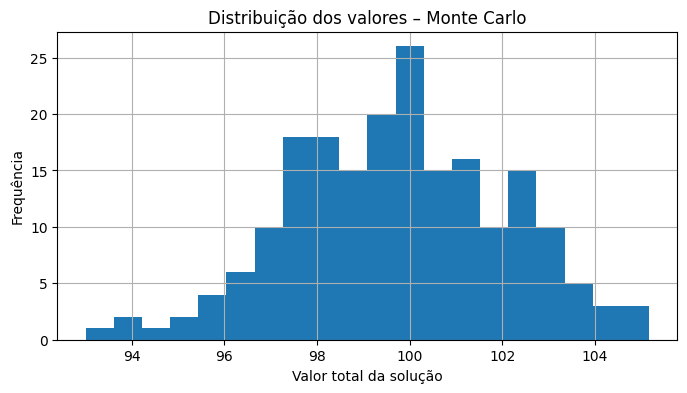

Top 5 soluções mais frequentes:


,solucao,frequencia,frequencia_relativa
0,"H11,S1,S2,S3,S5,S8",90,0.450
1,"S1,S2,S3,S4,S5,S6,S8",87,0.435
2,"S1,S2,S3,S4,S5,S6,S7",23,0.115


In [18]:
#@title 5.5. Monte Carlo: análise dos resultados

n_cenarios = 200  # ajuste se quiser
result_mc = simulate_monte_carlo(skills_base_data, n_scenarios=n_cenarios)

print(f"Número de cenários: {n_cenarios}")
print("Valor médio:", result_mc["media_valor"])
print("Desvio padrão:", result_mc["desvio_valor"])
print("Tempo de execução (s):", result_mc["tempo_execucao_s"])

plt.hist(result_mc["valores"], bins=20)
plt.xlabel("Valor total da solução")
plt.ylabel("Frequência")
plt.title("Distribuição dos valores – Monte Carlo")
plt.show()

top_solucoes = sorted(
    result_mc["frequencia_solucoes"].items(),
    key=lambda kv: kv[1],
    reverse=True
)[:5]

df_top_solucoes = pd.DataFrame(
    [
        {
            "solucao": ",".join(sol),
            "frequencia": freq,
            "frequencia_relativa": freq / n_cenarios,
        }
        for sol, freq in top_solucoes
    ]
)
print("Top 5 soluções mais frequentes:")
display(df_top_solucoes)


## 6. Desafio 2 – Habilidades críticas (S3, S5, S7, S8, S9)

Neste desafio avaliamos todas as permutações possíveis das habilidades críticas
e medimos o impacto no tempo e no valor acumulado. Assim, identificamos as
ordens mais eficientes de aprendizado.


In [19]:
#@title 6.1. Avaliação das permutações críticas

CRITICAS = ["S3", "S5", "S7", "S8", "S9"]

def evaluate_critical_order(
    graph: SkillGraph,
    order: Iterable[str],
    incluir_outros_prereqs: bool = True,
) -> Dict:
    """
    Simula seguir uma determinada ordem para as skills críticas.
    """
    ordem = list(order)
    aprendidas = set()
    tempo_total = 0.0
    valor_total = 0.0
    compl_total = 0.0

    for sid in ordem:
        skill = graph.get_skill(sid)

        if incluir_outros_prereqs:
            for p in skill.prereqs:
                if p not in aprendidas:
                    sp = graph.get_skill(p)
                    tempo_total += sp.tempo
                    valor_total += sp.valor
                    compl_total += sp.complexidade
                    aprendidas.add(p)
        else:
            if not set(skill.prereqs).issubset(aprendidas):
                return {"ordem": ordem, "valida": False}

        if sid not in aprendidas:
            tempo_total += skill.tempo
            valor_total += skill.valor
            compl_total += skill.complexidade
            aprendidas.add(sid)

    return {
        "ordem": ordem,
        "valida": True,
        "tempo_total": tempo_total,
        "valor_total": valor_total,
        "complexidade_total": compl_total,
        "quantidade_aprendidas": len(aprendidas),
    }


def avaliar_todas_ordens_criticas(
    graph: SkillGraph,
    criticas: List[str] = CRITICAS,
) -> List[Dict]:
    resultados = []
    for perm in itertools.permutations(criticas):
        res = evaluate_critical_order(graph, perm)
        if res.get("valida", False):
            resultados.append(res)

    resultados.sort(key=lambda r: (-r["valor_total"], r["tempo_total"]))
    return resultados


In [20]:
#@title 6.2. Top 3 ordens críticas

resultados_criticas = avaliar_todas_ordens_criticas(graph_base)
print("Total de ordens válidas:", len(resultados_criticas))

top3 = resultados_criticas[:3]
df_top3 = pd.DataFrame(
    [
        {
            "ordem": " → ".join(r["ordem"]),
            "valor_total": r["valor_total"],
            "tempo_total": r["tempo_total"],
            "complexidade_total": r["complexidade_total"],
            "qtd_habilidades": r["quantidade_aprendidas"],
        }
        for r in top3
    ]
)
display(df_top3)


Total de ordens válidas: 120


,ordem,valor_total,tempo_total,complexidade_total,qtd_habilidades
0,S3 → S5 → S7 → S8 → S9,127.0,440.0,33.0,8
1,S3 → S5 → S7 → S9 → S8,127.0,440.0,33.0,8
2,S3 → S5 → S8 → S7 → S9,127.0,440.0,33.0,8


## 7. Desafio 3 – Pivô mais rápido (guloso x ótimo)

Aqui comparamos:

- uma heurística simples, que escolhe habilidades na ordem de melhor razão `valor/tempo`;  
- uma busca exaustiva que encontra a combinação com menor tempo para atingir uma adaptabilidade mínima.

Isso ilustra a diferença entre uma solução rápida e uma solução garantidamente ótima.


In [21]:
#@title 7.1. Estratégias gulosa e ótima

def adaptabilidade_total(skills: Iterable[Skill]) -> float:
    """
    Neste trabalho, adaptabilidade = soma dos valores.
    """
    return sum(s.valor for s in skills)


def greedy_pivot(
    skills: List[Skill],
    min_adaptabilidade: float,
) -> List[Skill]:
    """
    Escolhe skills em ordem de valor/tempo até atingir a meta.
    """
    ordenadas = sorted(
        skills, key=lambda s: (s.valor / s.tempo), reverse=True
    )
    escolhidas: List[Skill] = []
    for s in ordenadas:
        if adaptabilidade_total(escolhidas) >= min_adaptabilidade:
            break
        escolhidas.append(s)
    return escolhidas


def optimal_pivot(
    skills: List[Skill],
    min_adaptabilidade: float,
) -> List[Skill]:
    """
    Procura a combinação com menor tempo que atinge a adaptabilidade mínima.
    """
    n = len(skills)
    melhor: Optional[List[Skill]] = None
    melhor_tempo = math.inf

    for mask in range(1 << n):
        subset = [skills[i] for i in range(n) if mask & (1 << i)]
        adap = adaptabilidade_total(subset)
        if adap >= min_adaptabilidade:
            tempo_total = sum(s.tempo for s in subset)
            if tempo_total < melhor_tempo:
                melhor_tempo = tempo_total
                melhor = subset
    return melhor or []


In [22]:
#@title 7.2. Comparação guloso x ótimo

skills_sem_prereq = graph_base.skills_without_prereqs()
print("Skills sem pré-req:", [s.id for s in skills_sem_prereq])

min_adap = 20  # ajustar se quiser outra meta
greedy_sol = greedy_pivot(skills_sem_prereq, min_adap)
optimal_sol = optimal_pivot(skills_sem_prereq, min_adap)

linhas = []
linhas.append({
    "algoritmo": "Guloso",
    "skills": ", ".join(s.id for s in greedy_sol),
    "adaptabilidade": adaptabilidade_total(greedy_sol),
    "tempo_total": sum(s.tempo for s in greedy_sol),
})
linhas.append({
    "algoritmo": "Ótimo",
    "skills": ", ".join(s.id for s in optimal_sol),
    "adaptabilidade": adaptabilidade_total(optimal_sol),
    "tempo_total": sum(s.tempo for s in optimal_sol),
})

df_comp = pd.DataFrame(linhas)
display(df_comp)


Skills sem pré-req: ['S1', 'S2']


,algoritmo,skills,adaptabilidade,tempo_total
0,Guloso,"S2, S1",18.0,70.0
1,Ótimo,,0.0,0.0


## 8. Desafio 4 – Trilhas paralelas (Merge Sort)

Agora ordenamos as habilidades por complexidade, implementando Merge Sort “na mão”
e comparando com o `sorted` nativo. Em seguida, dividimos em:

- **Sprint A**: 6 habilidades menos complexas  
- **Sprint B**: 6 habilidades mais complexas  


In [23]:
#@title 8.1. Merge Sort de habilidades

def merge(left: List[Skill], right: List[Skill], key) -> List[Skill]:
    result: List[Skill] = []
    i = j = 0
    while i < len(left) and j < len(right):
        if key(left[i]) <= key(right[j]):
            result.append(left[i])
            i += 1
        else:
            result.append(right[j])
            j += 1
    result.extend(left[i:])
    result.extend(right[j:])
    return result


def merge_sort_skills(skills: List[Skill], key=lambda s: s.complexidade) -> List[Skill]:
    if len(skills) <= 1:
        return skills[:]
    mid = len(skills) // 2
    left = merge_sort_skills(skills[:mid], key)
    right = merge_sort_skills(skills[mid:], key)
    return merge(left, right, key)


In [24]:
#@title 8.2. Ordenação e definição de sprints

skills_lista = list(graph_base.skills.values())

inicio = time.perf_counter()
ordenadas_merge = merge_sort_skills(skills_lista, key=lambda s: s.complexidade)
fim = time.perf_counter()
tempo_merge = fim - inicio

inicio2 = time.perf_counter()
ordenadas_sorted = sorted(skills_lista, key=lambda s: s.complexidade)
fim2 = time.perf_counter()
tempo_sorted = fim2 - inicio2

print("Tempo Merge Sort:", tempo_merge)
print("Tempo sort nativo:", tempo_sorted)

sprint_A = ordenadas_merge[:6]
sprint_B = ordenadas_merge[6:]

df_sprint_A = pd.DataFrame(
    [{"id": s.id, "complexidade": s.complexidade, "valor": s.valor, "tempo": s.tempo}
     for s in sprint_A]
).set_index("id")

df_sprint_B = pd.DataFrame(
    [{"id": s.id, "complexidade": s.complexidade, "valor": s.valor, "tempo": s.tempo}
     for s in sprint_B]
).set_index("id")

print("\nSprint A (menos complexas):")
display(df_sprint_A)

print("\nSprint B (mais complexas):")
display(df_sprint_B)


Tempo Merge Sort: 0.00023999499995852602
Tempo sort nativo: 0.00015471199998273732

Sprint A (menos complexas):


,complexidade,valor,tempo
id,,,
S2,2.0,8.0,30.0
S1,3.0,10.0,40.0
S4,3.0,12.0,45.0
S6,3.0,14.0,40.0
S3,4.0,15.0,50.0
S9,4.0,16.0,55.0



Sprint B (mais complexas):


,complexidade,valor,tempo
id,,,
S5,5.0,18.0,60.0
S7,5.0,20.0,70.0
H10,5.0,24.0,75.0
S8,6.0,22.0,80.0
H11,6.0,26.0,85.0
H12,7.0,30.0,90.0


## 9. Desafio 5 – Recomendações (horizonte de 5 anos)

Por fim, definimos alguns cenários de mercado e calculamos um **valor esperado**
para cada habilidade, levando em conta:

- probabilidade de cada cenário  
- peso que aquele cenário dá a determinadas habilidades  

Com isso, o MOH consegue sugerir próximos passos a partir do conjunto de habilidades atuais.


In [25]:
#@title 9.1. Cenários de mercado e função de recomendação

cenarios_mercado = {
    # Exemplo de configuração. Pode ser ajustado e justificado no relatório.
    "IA_Forte": {
        "prob": 0.4,
        "pesos": {
            "S7": 1.3, "S8": 1.4, "S9": 1.2, "H10": 1.5, "H11": 1.5, "H12": 1.6,
        },
    },
    "FullStack": {
        "prob": 0.35,
        "pesos": {
            "S1": 1.3, "S2": 1.2, "S3": 1.1, "S4": 1.3, "S5": 1.2,
        },
    },
    "Dados": {
        "prob": 0.25,
        "pesos": {
            "S6": 1.3, "S7": 1.2, "S9": 1.4, "H10": 1.3,
        },
    },
}


def valor_esperado_skill(skill: Skill, cenarios: Dict) -> float:
    total = 0.0
    for nome, info in cenarios.items():
        prob = info["prob"]
        peso = info["pesos"].get(skill.id, 1.0)
        total += prob * skill.valor * peso
    return total


def recomendar_proximas_habilidades(
    graph: SkillGraph,
    habilidades_atuais: List[str],
    cenarios: Dict,
    k: int = 3,
) -> List[Tuple[Skill, float]]:
    atuais_set = set(habilidades_atuais)
    candidatas = [s for s in graph.skills.values() if s.id not in atuais_set]

    recomendacoes: List[Tuple[Skill, float]] = []
    for s in candidatas:
        # modelo simples: só considera habilidades cujos pré-reqs já foram feitos
        if not set(s.prereqs).issubset(atuais_set):
            continue
        ve = valor_esperado_skill(s, cenarios)
        recomendacoes.append((s, ve))

    recomendacoes.sort(key=lambda x: x[1], reverse=True)
    return recomendacoes[:k]


In [26]:
#@title 9.2. Exemplo de recomendações

habilidades_atuais_exemplo = ["S1", "S2", "S3", "S5"]  # ajustar conforme cenário analisado

recs = recomendar_proximas_habilidades(
    graph_base,
    habilidades_atuais=habilidades_atuais_exemplo,
    cenarios=cenarios_mercado,
    k=3,
)

df_recs = pd.DataFrame(
    [
        {
            "id": s.id,
            "valor_atual": s.valor,
            "valor_esperado": ve,
            "tempo": s.tempo,
            "complexidade": s.complexidade,
        }
        for s, ve in recs
    ]
).set_index("id")

print("Habilidades atuais:", habilidades_atuais_exemplo)
print("\nSugestões de próximas habilidades:")
display(df_recs)


Habilidades atuais: ['S1', 'S2', 'S3', 'S5']

Sugestões de próximas habilidades:


,valor_atual,valor_esperado,tempo,complexidade
id,,,,
S8,22.0,25.52,80.0,6.0
S6,14.0,15.05,40.0,3.0
S4,12.0,13.26,45.0,3.0


In [27]:
#@title 10. Painel de experimentos

acao = "DP determinístico"  #@param ["DP determinístico", "Monte Carlo", "Ordens críticas", "Guloso vs Ótimo", "Ordenação e Sprints", "Recomendações"]

graph_base = SkillGraph(skills_base_data)

if acao == "DP determinístico":
    valor_max, subset_max, stats_exec = solve_deterministic_exaustivo(graph_base)
    print("Melhor valor:", valor_max)
    print("Conjunto:", subset_max)
    print("Stats:", stats_exec)

elif acao == "Monte Carlo":
    n_scenarios = 1600  #@param {type:"slider", min:50, max:2000, step:50}
    result_mc = simulate_monte_carlo(skills_base_data, n_scenarios=n_scenarios)
    print("Valor médio:", result_mc["media_valor"])
    print("Desvio:", result_mc["desvio_valor"])
    plt.hist(result_mc["valores"], bins=20)
    plt.show()

elif acao == "Ordens críticas":
    resultados_criticas = avaliar_todas_ordens_criticas(graph_base)
    df = pd.DataFrame(
        [
            {
                "ordem": " → ".join(r["ordem"]),
                "valor_total": r["valor_total"],
                "tempo_total": r["tempo_total"],
            }
            for r in resultados_criticas[:5]
        ]
    )
    display(df)

elif acao == "Guloso vs Ótimo":
    skills_sem_prereq = graph_base.skills_without_prereqs()
    min_adap = 20
    greedy_sol = greedy_pivot(skills_sem_prereq, min_adap)
    optimal_sol = optimal_pivot(skills_sem_prereq, min_adap)
    df = pd.DataFrame(
        [
            {
                "algoritmo": "Guloso",
                "skills": ", ".join(s.id for s in greedy_sol),
                "adaptabilidade": adaptabilidade_total(greedy_sol),
                "tempo_total": sum(s.tempo for s in greedy_sol),
            },
            {
                "algoritmo": "Ótimo",
                "skills": ", ".join(s.id for s in optimal_sol),
                "adaptabilidade": adaptabilidade_total(optimal_sol),
                "tempo_total": sum(s.tempo for s in optimal_sol),
            },
        ]
    )
    display(df)

elif acao == "Ordenação e Sprints":
    skills_lista = list(graph_base.skills.values())
    ordenadas = merge_sort_skills(skills_lista, key=lambda s: s.complexidade)
    print("Ordem por complexidade:", [s.id for s in ordenadas])

elif acao == "Recomendações":
    habilidades_atuais_exemplo = ["S1", "S2", "S3", "S5"]
    recs = recomendar_proximas_habilidades(
        graph_base,
        habilidades_atuais=habilidades_atuais_exemplo,
        cenarios=cenarios_mercado,
        k=3,
    )
    df_recs = pd.DataFrame(
        [
            {
                "id": s.id,
                "valor_atual": s.valor,
                "valor_esperado": ve,
                "tempo": s.tempo,
                "complexidade": s.complexidade,
            }
            for s, ve in recs
        ]
    ).set_index("id")
    display(df_recs)


Melhor valor: 99.0
Conjunto: ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S8']
Stats: {'subconjuntos_avaliados': 4096, 'tempo_execucao_s': 0.08284999299996798}


In [28]:
#@title 11. Relatório Final – Caminhos, Custos e Métricas

print("===== RELATÓRIO FINAL DO MOH =====\n")

# --- Caminho ótimo (DP determinístico) ---
valor_max, subset_max, stats_exec = solve_deterministic_exaustivo(graph_base)
df_escolhidas = pd.DataFrame(
    [
        {
            "id": sid,
            "valor": graph_base.get_skill(sid).valor,
            "tempo": graph_base.get_skill(sid).tempo,
            "complexidade": graph_base.get_skill(sid).complexidade,
        }
        for sid in subset_max
    ]
).set_index("id")
df_totais = pd.DataFrame({
    "valor_total": [df_escolhidas["valor"].sum()],
    "tempo_total": [df_escolhidas["tempo"].sum()],
    "complexidade_total": [df_escolhidas["complexidade"].sum()],
})

print("📌 Caminho ótimo encontrado (DP):")
print(" → " + " → ".join(subset_max))
print("\n📊 Custos totais:")
display(df_totais)

print("\n⚙️ Métricas da execução DP:")
print(f"- Subconjuntos avaliados: {stats_exec['subconjuntos_avaliados']}")
print(f"- Tempo de execução: {stats_exec['tempo_execucao_s']:.4f} s\n")

# --- Monte Carlo ---
print("🎲 Monte Carlo (Resumo):")
result_mc = simulate_monte_carlo(skills_base_data, n_scenarios=200)
print(f"- Valor médio: {result_mc['media_valor']:.2f}")
print(f"- Desvio padrão: {result_mc['desvio_valor']:.2f}")
print(f"- Tempo de execução: {result_mc['tempo_execucao_s']:.4f} s")

# Top 3 soluções mais frequentes
top3 = sorted(
    result_mc["frequencia_solucoes"].items(),
    key=lambda x: x[1],
    reverse=True
)[:3]
df_top3 = pd.DataFrame(
    [{"solucao": ",".join(sol), "frequencia": freq} for sol, freq in top3]
)
print("\n🥇 Soluções mais frequentes no Monte Carlo:")
display(df_top3)

# --- Pivô (guloso vs ótimo) ---
skills_sem_prereq = graph_base.skills_without_prereqs()
min_adap = 20
greedy_sol = greedy_pivot(skills_sem_prereq, min_adap)
optimal_sol = optimal_pivot(skills_sem_prereq, min_adap)

df_pivo = pd.DataFrame([
    {
        "algoritmo": "Guloso",
        "skills": ", ".join(s.id for s in greedy_sol),
        "adaptabilidade": adaptabilidade_total(greedy_sol),
        "tempo_total": sum(s.tempo for s in greedy_sol),
    },
    {
        "algoritmo": "Ótimo",
        "skills": ", ".join(s.id for s in optimal_sol),
        "adaptabilidade": adaptabilidade_total(optimal_sol),
        "tempo_total": sum(s.tempo for s in optimal_sol),
    },
])
print("⚔️ Comparação Guloso vs Ótimo:")
display(df_pivo)

print("\n===== FIM DO RELATÓRIO =====")


===== RELATÓRIO FINAL DO MOH =====

📌 Caminho ótimo encontrado (DP):
 → S1 → S2 → S3 → S4 → S5 → S6 → S8

📊 Custos totais:


,valor_total,tempo_total,complexidade_total
0,99.0,345.0,26.0



⚙️ Métricas da execução DP:
- Subconjuntos avaliados: 4096
- Tempo de execução: 0.0101 s

🎲 Monte Carlo (Resumo):
- Valor médio: 99.87
- Desvio padrão: 2.11
- Tempo de execução: 2.0897 s

🥇 Soluções mais frequentes no Monte Carlo:


,solucao,frequencia
0,"S1,S2,S3,S4,S5,S6,S8",89
1,"H11,S1,S2,S3,S5,S8",84
2,"S1,S2,S3,S4,S5,S6,S7",27


⚔️ Comparação Guloso vs Ótimo:


,algoritmo,skills,adaptabilidade,tempo_total
0,Guloso,"S2, S1",18.0,70.0
1,Ótimo,,0.0,0.0



===== FIM DO RELATÓRIO =====
